In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sys import platform
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# uncomment lines above when using Google Colab

Mounted at /content/drive


# 0. Import Dataset

In [ ]:
day2 = pd.read_csv('Day2.csv')
day4 = pd.read_csv('day4.csv')
day5 = pd.read_csv('day5.csv')
day6 = pd.read_csv('day6.csv')

In [ ]:
day2.head()

,DATE_TIME,END_DATE_TIME,IVA_CHAT_ID,CHAT_TYPE,CLIENT_ID,LOGIN_STATE,IVA_CHAT_REASON,INPUT,RESPONSE
0,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,0000_Charge Not Listed,I just made a purchase of a kayak on my card b...,I've taken you to the page where you can view ...
1,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,OnUserLogIn,OnUserLogIn,Thank you for logging in.<br/><br/>
2,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,WelcomeUser,WelcomeUser,"Hi, I?m Sydney, your Virtual Assistant! Just s..."
3,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,HostPageData,HostPageData,NaN
4,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,025_Need Card Information,How do I find account number,For your security I can't give out your accoun...


In [ ]:
day4.head()

,DATE_TIME,END_DATE_TIME,IVA_CHAT_ID,CHAT_TYPE,CLIENT_ID,LOGIN_STATE,IVA_CHAT_REASON,INPUT,RESPONSE
0,10/4/21 0:00,10/4/21 0:04,74117548,Deflected,PayPal Credit,postlogin,PON_LoginError,PointOfNeed,"I noticed you're having trouble logging in, I ..."
1,10/4/21 0:00,10/4/21 0:04,74117548,Deflected,PayPal Credit,postlogin,WelcomeUser,WelcomeUser,"Hi, I?m Sydney, your Virtual Assistant! Just s..."
2,10/4/21 0:00,10/4/21 0:04,74117548,Deflected,PayPal Credit,postlogin,HostPageData,HostPageData,NaN
3,10/4/21 0:00,10/4/21 0:04,74117548,Deflected,PayPal Credit,postlogin,0000_Tied Units,I went through PayPal with Verizon to but a ph...,I have a few topics related to your question. ...
4,10/4/21 0:00,10/4/21 0:04,74117548,Deflected,PayPal Credit,postlogin,149_Dispute a Charge,Dispute a charge,"I'm sorry, this feature isn't available on mob..."


In [ ]:
day5.head()

,DATE_TIME,END_DATE_TIME,IVA_CHAT_ID,CHAT_TYPE,CLIENT_ID,LOGIN_STATE,IVA_CHAT_REASON,INPUT,RESPONSE
0,10/5/21 0:00,10/5/21 0:01,74195838,Deflected,Amazon,postlogin,GradingComplete,GradingComplete,Thank you for your feedback.
1,10/5/21 0:00,10/5/21 0:01,74195838,Deflected,Amazon,postlogin,HostPageData,HostPageData,NaN
2,10/5/21 0:00,10/5/21 0:01,74195838,Deflected,Amazon,postlogin,WelcomeUser,WelcomeUser,"Hi, I?m Sydney, your Virtual Assistant! Just s..."
3,10/5/21 0:00,10/5/21 0:01,74195838,Deflected,Amazon,postlogin,GradingComplete,GradingComplete,Thank you for your feedback.
4,10/5/21 0:00,10/5/21 0:01,74195838,Deflected,Amazon,postlogin,153_Autopay Clarifier,auto pay didnnt go thru,I see you asked me to about Auto Pay. I've pro...


In [ ]:
day6.head()

,DATE_TIME,END_DATE_TIME,IVA_CHAT_ID,CHAT_TYPE,CLIENT_ID,LOGIN_STATE,IVA_CHAT_REASON,INPUT,RESPONSE
0,10/6/21 0:00,10/6/21 0:08,74251232,LiveChat,Consumer Center,prelogin,OnUserLogIn,OnUserLogIn,Thank you for logging in.
1,10/6/21 0:00,10/6/21 0:08,74251232,LiveChat,Consumer Center,prelogin,WelcomeUser,WelcomeUser,"Hi, I'm Sydney! I may be able to answer your q..."
2,10/6/21 0:00,10/6/21 0:08,74251232,LiveChat,Consumer Center,prelogin,HostPageData,HostPageData,NaN
3,10/6/21 0:00,10/6/21 0:08,74251232,LiveChat,Consumer Center,prelogin,NaN,Thanks!,NaN
4,10/6/21 0:00,10/6/21 0:08,74251232,LiveChat,Consumer Center,prelogin,NaN,I need to if possible delay my October payment...,NaN


In [ ]:
df = pd.concat([day2, day4, day5, day6], axis = 0,ignore_index = True)
df.head()

,DATE_TIME,END_DATE_TIME,IVA_CHAT_ID,CHAT_TYPE,CLIENT_ID,LOGIN_STATE,IVA_CHAT_REASON,INPUT,RESPONSE
0,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,0000_Charge Not Listed,I just made a purchase of a kayak on my card b...,I've taken you to the page where you can view ...
1,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,OnUserLogIn,OnUserLogIn,Thank you for logging in.<br/><br/>
2,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,WelcomeUser,WelcomeUser,"Hi, I?m Sydney, your Virtual Assistant! Just s..."
3,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,HostPageData,HostPageData,NaN
4,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,025_Need Card Information,How do I find account number,For your security I can't give out your accoun...


# **1. Exploratory Data Analysis**

## 1.1 Check for data types, Distributions, and Null values

In [ ]:
df.shape

(3571711, 9)

In [ ]:
df.isnull().sum()

DATE_TIME                0
END_DATE_TIME            0
IVA_CHAT_ID              0
CHAT_TYPE                0
CLIENT_ID                0
LOGIN_STATE              0
IVA_CHAT_REASON    1626007
INPUT              1234860
RESPONSE           1400659
dtype: int64

In [ ]:
df['LOGIN_STATE'].value_counts()

postlogin    2493191
prelogin     1078520
Name: LOGIN_STATE, dtype: int64

In [ ]:
df['CHAT_TYPE'].value_counts()

Deflected    1862838
LiveChat     1706509
Error           2364
Name: CHAT_TYPE, dtype: int64

## 1.2 Correlation Analysis Between LOGIN_STATE and CHAT_TYPE

### 1.2.1 Heatmap

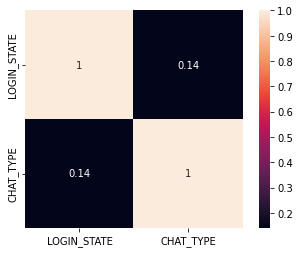

In [ ]:
heatmap_data = pd.DataFrame({"LOGIN_STATE":[],"CHAT_TYPE":[]})
loginstate = df['LOGIN_STATE'].map({'prelogin':0, 'postlogin':1})
chattype = df['CHAT_TYPE'].map({'Error':0, 'Deflected':1, 'LiveChat':2})
heatmap_data["LOGIN_STATE"] = loginstate
heatmap_data["CHAT_TYPE"] = chattype
col_names = ["LOGIN_STATE", "CHAT_TYPE"]
sns.heatmap(heatmap_data.astype(float).corr(), square = True, annot = True)

As the variable is a categorical variable, we have arbitarily assigned numbers to each category to draw a correlation graph. We have noticed relatively low (<0.7) correlation implying that the correlation is not significant. However, as the correlation plot was drawn based on our given values, we decided to investigate furthur.

### 1.2.2 Bar Plot

In [ ]:
cross = pd.crosstab(index=df['LOGIN_STATE'],columns=df['CHAT_TYPE'])
print(cross)

CHAT_TYPE    Deflected  Error  LiveChat
LOGIN_STATE                            
postlogin      1186003    975   1306213
prelogin        676835   1389    400296


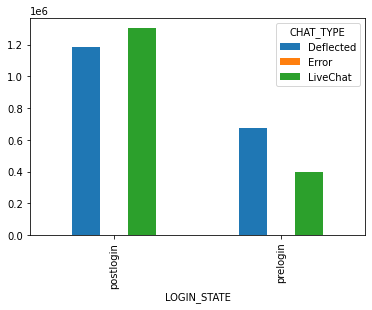

In [ ]:
cross.plot(kind='bar')

According to the bar graph, the association between our response variable and our predictor variable is stating that if a customer's LOGIN_STATUS is postlogin, it is more likely for the customer to move on to live chat. On the other hand, if the consumer status is prelogin, it is more likely for the customer to end the chat with Sydney and deflect. However, looking at the graph, the total volume of customers for postlogin and prelogin vary significantly. Therefore, it would not be reasonable to conclude a direct correlation between two variables. Furthermore, since the LOGIN_STATUS is a variable indicating the customer's log in status to the website, it is hard to assume that it affects the customer's satisfaction.

# **2. Data Preprocessing**

## 2.1 Drop rows & Null values

Change the values in "IVA_CHAT_REASON," "INPUT," "REPONSE" column to lowercase to avoid case-mismatching error

In [ ]:
df["IVA_CHAT_REASON"] = df["IVA_CHAT_REASON"].str.lower()
df["INPUT"] = df["INPUT"].str.lower()
df["RESPONSE"] = df["RESPONSE"].str.lower()
df.head()

,DATE_TIME,END_DATE_TIME,IVA_CHAT_ID,CHAT_TYPE,CLIENT_ID,LOGIN_STATE,IVA_CHAT_REASON,INPUT,RESPONSE
0,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,0000_charge not listed,i just made a purchase of a kayak on my card b...,i've taken you to the page where you can view ...
1,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,onuserlogin,onuserlogin,thank you for logging in.<br/><br/>
2,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,welcomeuser,welcomeuser,"hi, i?m sydney, your virtual assistant! just s..."
3,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,hostpagedata,hostpagedata,NaN
4,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,025_need card information,how do i find account number,for your security i can't give out your accoun...


In [ ]:
print(len(df.loc[df.INPUT == "welcomeuser"]["RESPONSE"]))
print(len(df.loc[df.INPUT == "welcomeuser"]["RESPONSE"].unique()))

print(len(df.loc[df.INPUT == "hostpagedata"]["RESPONSE"]))
print(len(df.loc[df.INPUT == "hostpagedata"]["RESPONSE"].unique()))

print(len(df.loc[df.INPUT == "onuserlogin"]["RESPONSE"]))
print(len(df.loc[df.INPUT == "onuserlogin"]["RESPONSE"].unique()))

284775
31
280944
1
217644
830


From the result above, we can see that for data points that has value "welcomeuser" in "INPUT" column, their values in "RESPONSE" column varies within 31 values only. With the same manner, if the "INPUT" value is equal to "hostpagedata" or "onuserlogin", they vary within 1 or 830 options, which is very small compared to their volumne. Firthermore, intuitively, the chatbot's response to those reasons would be habitual. Therefore, we decide to drop rows with "INPUT" value equal to "hostpagedata," "welcomeuser," "onuserlogin." 

In [ ]:
df.drop(df[df.IVA_CHAT_REASON == "welcomeuser"].index, inplace=True)
df.drop(df[df.IVA_CHAT_REASON == "onuserlogin"].index, inplace=True)
df.drop(df[df.IVA_CHAT_REASON == "hostpagedata"].index, inplace=True)
df.drop(df[df.CHAT_TYPE == "error"].index, inplace=True)
print(df.shape)

(2794490, 9)


In [ ]:
print(df[df["INPUT"].isnull() & df["RESPONSE"].isnull() & df["IVA_CHAT_REASON"].isnull()].shape)
INT_RES_NULL= df[df["INPUT"].isnull() & df["RESPONSE"].isnull() & df["IVA_CHAT_REASON"].isnull()]
drop_idx = INT_RES_NULL.index
df = df.drop(drop_idx)
df.shape
#

(565365, 9)


(2229125, 9)

We have found that there were null values in all three predictor variables at the exact same row and deleted those as their volume was trivial to the number of total observations. 


## 2.2 Group rows by IVA_CHAT_ID

In [ ]:
df["IVA_CHAT_REASON"] = df["IVA_CHAT_REASON"].astype(str)
df["INPUT"] = df["INPUT"].astype(str)
df["RESPONSE"] = df["RESPONSE"].astype(str)

df["IVA_CHAT_REASON"] = df.groupby("IVA_CHAT_ID")["IVA_CHAT_REASON"].transform(lambda x : ' '.join(x))
df["INPUT"] = df.groupby("IVA_CHAT_ID")["INPUT"].transform(lambda x : ' '.join(x))
df["RESPONSE"] = df.groupby("IVA_CHAT_ID")["RESPONSE"].transform(lambda x : ' '.join(x))

df = df.drop_duplicates()
df.head(30)

,DATE_TIME,END_DATE_TIME,IVA_CHAT_ID,CHAT_TYPE,CLIENT_ID,LOGIN_STATE,IVA_CHAT_REASON,INPUT,RESPONSE
0,02Oct2021 0:00:02.185,02Oct2021 0:00:15.823,74003553,Deflected,Consumer Center,prelogin,0000_charge not listed 025_need card information,i just made a purchase of a kayak on my card b...,i've taken you to the page where you can view ...
8,02Oct2021 0:00:08.385,02Oct2021 0:01:40.300,74003559,Deflected,Lowes,postlogin,0000_prompt: credit limit increase amount sele...,**** **** start: credit limit increase request...,please tell me the amount you want your credit...
17,02Oct2021 0:00:08.230,02Oct2021 0:00:31.147,74003560,Deflected,PayPal Credit,postlogin,0000_prompt: lost stolen card date,report my account lost or stolen,when was your account lost/stolen? all dates a...
21,02Oct2021 0:00:09.613,02Oct2021 0:11:11.260,74003562,Deflected,Amazon,prelogin,0000_prompt: hrt transmit 0000_start: account ...,closeform help with logging in pointofneed tra...,nan nan i noticed you're having trouble loggin...
29,02Oct2021 0:00:09.833,02Oct2021 0:01:38.090,74003563,Deflected,PayPal Credit,postlogin,gradingcomplete 215_fraudulent transaction,gradingcomplete transaction can?t recognize,thank you for your feedback. i'm sorry to hear...
32,02Oct2021 0:00:11.102,02Oct2021 0:05:13.642,74003564,Deflected,Amazon,postlogin,0000_increase credit limit 0000_weblink only: ...,increase credit limit credit limit increase ti...,"i'm sorry, this feature isn't available on mob..."
47,02Oct2021 0:00:15.424,02Oct2021 0:01:51.427,74003566,Deflected,PayPal Credit,postlogin,pon_loginerror 215_fraudulent transaction 206_...,pointofneed unauthorized charges someone has b...,"i noticed you're having trouble logging in, i ..."
56,02Oct2021 0:00:29.331,02Oct2021 0:12:26.495,74003571,LiveChat,PayPal Credit,postlogin,pon_loginerror 0000_appeventresponse: livechat...,pointofneed livechatsessionended no. that is i...,"i noticed you're having trouble logging in, i ..."
84,02Oct2021 0:00:31.274,02Oct2021 0:01:11.203,74003572,Deflected,PayPal Credit,postlogin,025_need card information 0000_account number ...,find my account number can i access my account...,i can tell you where to find your card informa...
94,02Oct2021 0:00:38.462,02Oct2021 0:07:12.444,74003582,Deflected,Lowes,postlogin,0000_start: account access login pon_loginerro...,help with logging in pointofneed gradingcomple...,nan i noticed you're having trouble logging in...


If multiple rows share the same CHAT_ID, they are from a single sequence of chat with a single customer. We want to decide the satisfaction by single customer. Therefore, we grouped the three predictor variables with the same Chat_ID and concatenated them as one string. 


## 2.3 Drop columns

In [ ]:
df.drop(["DATE_TIME","END_DATE_TIME","CLIENT_ID"],axis=1,inplace = True)
df.drop(["IVA_CHAT_REASON"],axis=1,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We have not included the “Date_Time”, “End_Date_Time”, and "Client_ID" as those variables were not important for interpreting chatbot efficiency and customer's satisfaction. 

# **3. Feature Engineering**

## 3.1 Map response variables

In [ ]:
df['CHAT_TYPE'] = df['CHAT_TYPE'].map({'Error':0, 'Deflected':1, 'LiveChat':2})

## 3.2 NLP using SpaCy

In [ ]:
import re
from collections import Counter
from itertools import chain
import spacy.cli
import en_vectors_web_lg
import nltk
from nltk.corpus import stopwords

# spacy.cli.download("en_vectors_web_lg")
# nltk.download('stopwords')
# make sure to download the above modules before running

✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')


In [ ]:
import en_vectors_web_lg
import nltk
from nltk.corpus import stopwords

In [ ]:
inputs = df['INPUT']
responses = df['RESPONSE']

chats = inputs + " " + responses

In [ ]:
def ProcessChats(chats, stopwords):
  """Removes irrelevant data from chats
  
  input: 
       chats: given chats to be processed
       stopwords: stopwords that will be removed from chats
  output:
       chats: processed chats  
  """
  # change to lower case
  chats = chats.str.lower()

  # remove special characters and numbers
  chats = chats.apply(lambda x : re.sub("[^a-z\s]","",x))

  # replace NaN value with empty string
  chats = chats.str.replace("nan", "")

  # remove stopwords
  chats = chats.apply(lambda x : " ".join(word for word in x.split() if word not in stopwords))

  return chats

In [ ]:
# create the stopwords set
stopwords = set(stopwords.words("english"))

# process inputs and responses
#inputs = ProcessChats(inputs, stopwords)
#responses = ProcessChats(responses, stopwords)
chats = ProcessChats(chats, stopwords)

In [ ]:
def top_n_chats(chats, n=25):
  """Return the series of n words with the highest frequency

  input:
       chats: given chats to identify the word frequency
       n: number of words (default == 25)
  output:
       top_chats: series of n words with the highest frequency
  """
  top_chats = pd.Series(' '.join(chats).lower().split()).value_counts()[:n]
  return top_chats

In [ ]:
# retrieve top 40 words with the highest frequency in inputs and responses
n = 40
#top_n_inputs = top_n_chats(inputs, n)
#top_n_responses = top_n_chats(responses, n)
top_n_chats = top_n_chats(chats, n)

In [ ]:
def remove_top_n_chats(chats, top_n_chats):
  chats = chats.apply(lambda x : " ".join(word for word in x.split() if word not in top_n_chats))
  return chats

In [ ]:
# remove top 40 words with the highest frequency (redundant words created by a chat bot)
#inputs = remove_top_n_chats(inputs, top_n_inputs)
#responses = remove_top_n_chats(responses, top_n_responses)
chats = remove_top_n_chats(chats, top_n_chats)

In [ ]:
def remove_unique_words(chats):
  v = chats.str.split().tolist()
  c = Counter(chain.from_iterable(v))
  chats = [' '.join([j for j in i if c[j] > 1]) for i in v]
  return chats

In [ ]:
# remove words with the frequency of 1
#inputs = remove_unique_words(inputs)
#responses = remove_unique_words(responses)
chats = remove_unique_words(chats)

In [ ]:
# loading English pipeline for Natural Language Processing
nlp = en_vectors_web_lg.load()

In [ ]:
def vectorization(chats):
  doc = nlp.pipe(chats)
  chats_vector = np.array([chat.vector for chat in doc])
  return chats_vector

In [ ]:
# vectorize inputs and responses
#inputs_vector = vectorization(inputs)
#responses_vector = vectorization(responses)
chats_vector = vectorization(chats)

# 4. Model Selection & Training

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
# contruct independent and dependent variables
X = chats_vector
y = df['CHAT_TYPE']

# split the test and traing dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

### 4.1 Decision Tree Classifier

In [ ]:
model1 = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(model1, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.80543742 0.8052799  0.80609898 0.80568944 0.80458068]


### 4.2 K Nearest Neighbor

In [ ]:
model2 = KNeighborsClassifier(n_neighbors=100)
scoring = 'accuracy'
score = cross_val_score(model2, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.79708912 0.79784519 0.80291718 0.80184608 0.80328902]


### 4.3 Logistic Regression

In [ ]:
model3 = LogisticRegression(C=10, max_iter=5000)
scoring = 'accuracy'
score = cross_val_score(model3, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.82695397 0.8230161  0.82670195 0.82336263 0.82540483]


### 4.4 Random Forest Classifier

In [ ]:
model4 = RandomForestClassifier(n_estimators=130)
scoring = 'accuracy'
score = cross_val_score(model4, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.869105   0.87064865 0.87071165 0.869105   0.87347993]


### 4.5 Model Selection

In [ ]:
print(np.array([0.80543742, 0.8052799,  0.80609898, 0.80568944, 0.80458068]).mean())
print(np.array([0.79708912, 0.79784519, 0.80291718, 0.80184608, 0.80328902]).mean())
print(np.array([0.82695397, 0.8230161 , 0.82670195, 0.82336263, 0.82540483]).mean())
print(np.array([0.869105,   0.87064865, 0.87071165, 0.869105,   0.87347993]).mean())

0.805417284
0.800597318
0.825087896
0.870610046


Among the model we have tested, Random Forest Classifier showed the best performance.

### 4.6 Logistic Regression (With Both INPUT and RESPONSE columns)

In [ ]:
model5 = LogisticRegression(C=10, max_iter=5000).fit(X_train, y_train)
print(model5.score(X_train, y_train))

0.9658631248661114


# 5. Testing & Model Output


In [ ]:
y_pred = model5.predict(X_val)
print(model5.score(X_val, y_val))

0.9654077417268196


# 6. Future Advice

In [ ]:
Deflected = df.loc[(df.CHAT_TYPE== 1 )].copy()
Deflected = Deflected.fillna(" ")
Deflected["WordCloudSource"] = Deflected["INPUT"]
Deflected["WordCloudSource"] = Deflected["WordCloudSource"].astype(str)
Deflected = Deflected["WordCloudSource"]
Deflected = Deflected.apply(lambda x : re.sub("[^A-Za-z\s]","",x))

In [ ]:
#Stopwords 
stopwords2 = set(STOPWORDS)
remove2 = set(['live', 'chat', 'hi', 'need', 'closeform', 'closeform pointofneed', 'pointofneed','pointofneed closeform', 
               'pointofneed help', 'help', 'logging', 'transmitresult', 'gradingcomplete', 'nan', 'nan nan'])
remove_words2 = set.union(stopwords2, remove2)

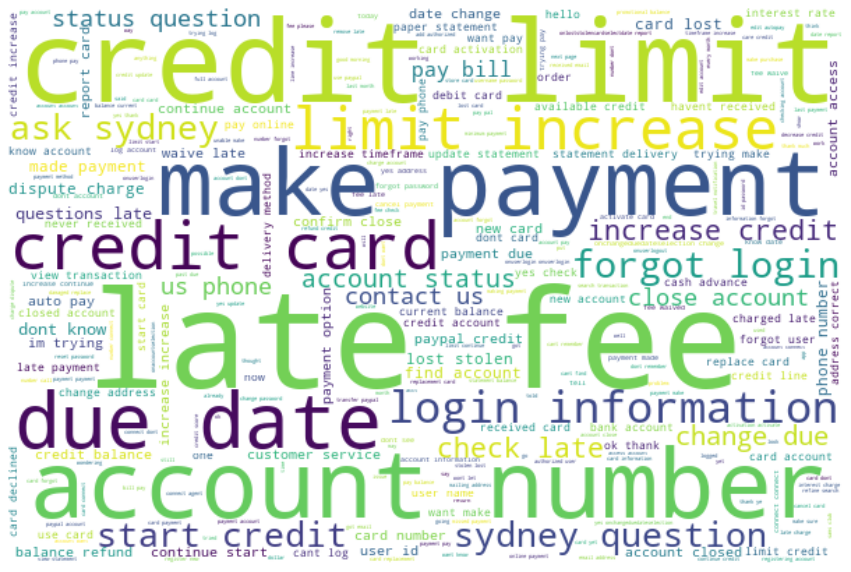

In [ ]:
wc2 = WordCloud(width = 600, height = 400, random_state=1, background_color='white', max_words=100000, collocations=True, stopwords = remove_words2).generate(' '.join(Deflected))
plt.figure(figsize=[15,15])
plt.imshow(wc2, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
LiveChat = df.loc[(df.CHAT_TYPE== 2 )].copy()
LiveChat = LiveChat.fillna(" ")
LiveChat["WordCloudSource"] = LiveChat["INPUT"]
LiveChat["WordCloudSource"] = LiveChat["WordCloudSource"].astype(str)
LiveChat = LiveChat["WordCloudSource"]
LiveChat = LiveChat.apply(lambda x : re.sub("[^A-Za-z\s]","",x))

In [ ]:
#Stopwords 
stopwords = set(STOPWORDS)
remove = set(['live', 'chat', 'hi', 'need', 'livechatsessionended', 'th','closeform', 'thank', 'pointofneed','pointofneed closeform', 
               'pointofneed help', 'help', 'logging', 'transmitResult', 'gradingComplete', 'nan', 'nan nan'])
remove_words = set.union(stopwords, remove)

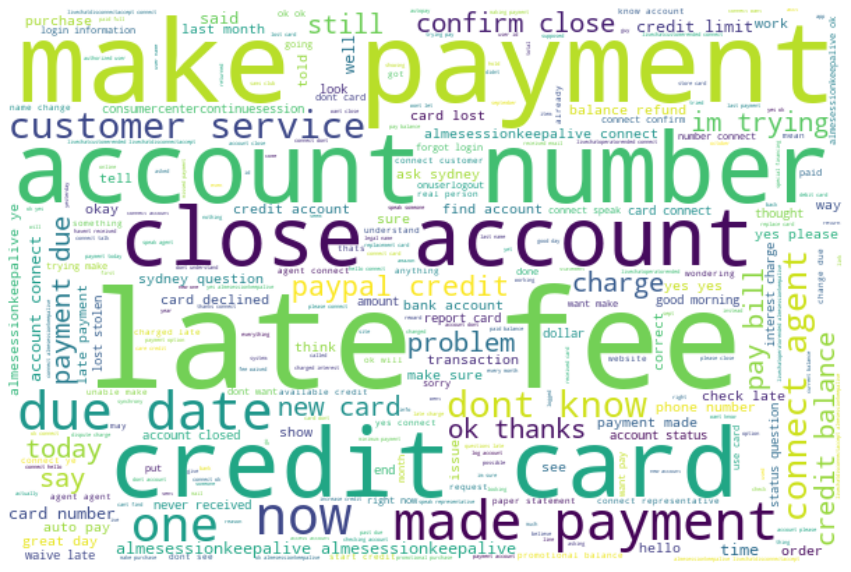

In [ ]:
wc = WordCloud(width = 600, height = 400, random_state=1, background_color='white', max_words=100000, collocations=True, stopwords = remove_words).generate(' '.join(LiveChat))
plt.figure(figsize=[15,15])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()